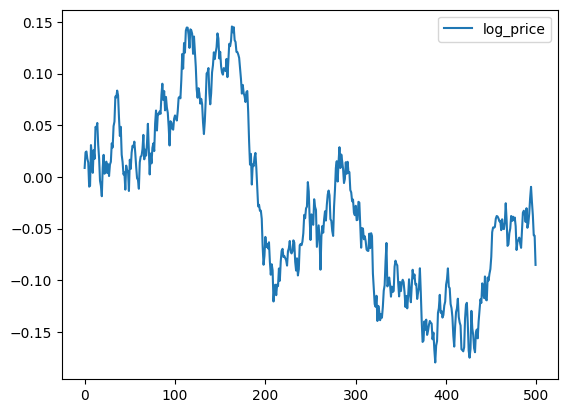

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# パラメータ設定
T = 500  # データの長さ
a = -0.8  # AR(1)過程のパラメータ
su = 0.01
sw = 0.0001

# ノイズ生成
u = np.random.normal(0, su, T)
u[1:] = a * u[:-1] + np.random.normal(0, su, T - 1)
w = np.random.normal(0, sw, T)
w[1:] = w[:-1] + np.random.normal(0, sw, T - 1)

# トレンドと対数価格の生成
trend = np.cumsum(w)
log_price = np.cumsum(trend + u)

# DataFrameに変換
df = pd.DataFrame({'log_price': log_price})
df.plot()
plt.show()

In [120]:
# カルマンフィルタの設定
kf = KalmanFilter(transition_matrices=[[1, 1], [0, 1]],
                  observation_matrices=[[1, 0]],
                  initial_state_mean=[0, 0],
                  initial_state_covariance=[[1, 0], [0, 1]],
                  observation_covariance=su,
                  transition_covariance=[[0, 0], [0, sw]])

In [121]:
# ポジション管理のための変数
position = 0  # 0: no position, 1: long, -1: short

lower95s = []
upper95s = []
lower60s = []
upper60s = []
trends = []
for i in range(len(df)):
    # カルマンフィルタの更新（i時刻までのデータでフィルタリング）
    state_means, state_covs = kf.filter(df['log_price'].values[:i+1])
    trends.append(state_means[-1,1])
    
    # 信頼区間の計算
    lower95 = state_means[-1, 0] - 0.1 * np.sqrt(state_covs[-1, 0, 0])
    upper95 = state_means[-1, 0] + 0.1 * np.sqrt(state_covs[-1, 0, 0])
    lower60 = state_means[-1, 0] - 0.0 * np.sqrt(state_covs[-1, 0, 0])
    upper60 = state_means[-1, 0] + 0.0 * np.sqrt(state_covs[-1, 0, 0])

    lower95s.append(lower95)
    upper95s.append(upper95)
    lower60s.append(lower60)
    upper60s.append(upper60)

df["lower95"] = lower95s
df["upper95"] = upper95s
df["lower60"] = lower60s
df["upper60"] = upper60s
df["trend"] = trends

In [122]:

df["long_entry"] = (df["log_price"] > df["upper95"]) & (df["trend"]>0)
df["short_entry"] = (df["log_price"] < df["lower95"]) & (df["trend"]<0)

df["long_close"] = df["log_price"] < df["lower60"]
df["short_close"] = df["log_price"] > df["upper60"]

<Axes: >

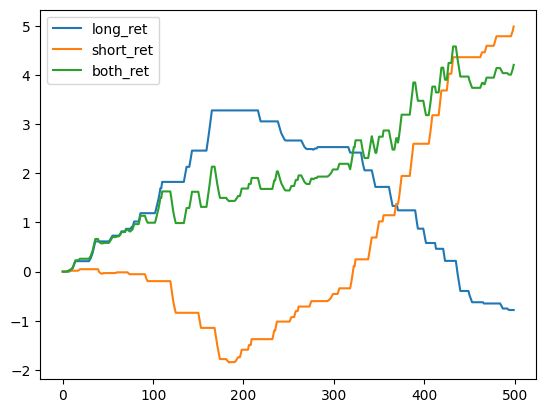

In [123]:
df["long_ret"] = 0.
pos = 0
for i, (entry, close, ret) in enumerate(zip(df["long_entry"], df["long_close"], df["log_price"])):
    if pos==0:
        if entry:
            pos += 1
            df.loc[i,"long_ret"] = ret
    if pos:
        if not close:
            df.loc[i,"long_ret"] = ret
        else:
            pos = 0


df["short_ret"] = 0.
pos = 0
for i, (entry, close, ret) in enumerate(zip(df["short_entry"], df["short_close"], df["log_price"])):
    if pos==0:
        if entry:
            pos += 1
            df.loc[i,"short_ret"] = -ret
    if pos:
        if not close:
            df.loc[i,"short_ret"] = -ret
        else:
            pos = 0

df["both_ret"] = df["short_ret"] + df["long_ret"]


df[["long_ret","short_ret", "both_ret"]].cumsum().plot()